## **Prediction of Maternal Health Risk Levels using XGBoost and SVM**

# **Introduction**

Inputs:

1.Age: Age in years when a woman is pregnant.

2.SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.

3.DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.

4.BS: Blood glucose levels is in terms of a molar concentration, mmol/L.

5.BodyTemp: Body temperatures as Fahrenheit.

6.HeartRate: A normal resting heart rate in beats per minute.

Outputs:

Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute; high, low, and mid risk.

# **1.Importing libraries and data**

In [51]:
# Exploratory data analysis and plotting libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.io import arff
import warnings
warnings.simplefilter("ignore")

# Feature Selection
import mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Models from Scikit-Learn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model evaluations 
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, average_precision_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [52]:
# For fixing random_state parameters
seed = 20

In [53]:
df = pd.read_csv("/kaggle/input/maternal-health-risk-data/Maternal Health Risk Data Set.csv")
o_df = df.copy()
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


# **2.Exploratory data analysis**

#### **2.1.General information about dtypes and null values**

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


#### **2.2.Number of observations and features**

In [55]:
df.shape

(1014, 7)

#### **2.3.Missing values**

In [56]:
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

There are no missing values.

#### **2.4.How many of each risk level?**

In [57]:
risk_levels = df["RiskLevel"].value_counts()
risk_levels_df = pd.DataFrame(risk_levels)
risk_levels_df = risk_levels.reset_index(level = 0)
risk_levels_df

,RiskLevel,count
0,low risk,406
1,mid risk,336
2,high risk,272


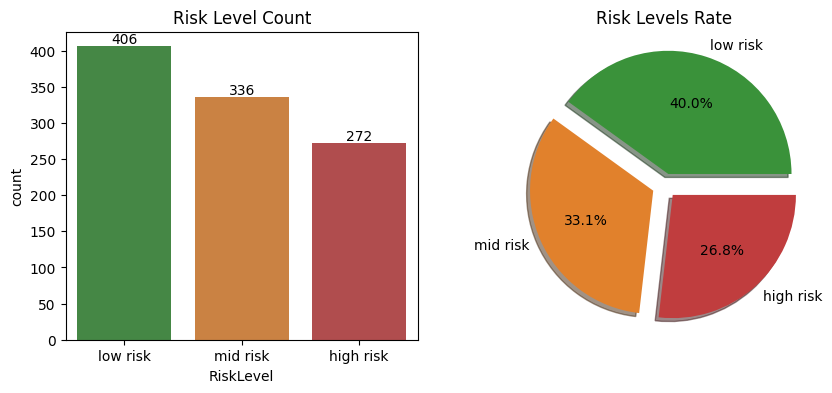

In [58]:
# Plotting risk level counts and rates
cmap = ["#3a923a","#e1812c","#c03d3e","#3274a1","#857aab","#8d7866"]

plt.subplots(1, 2, figsize = (10, 4))
plt.subplot(121)
ax = sns.barplot(data = risk_levels_df, 
                 x = risk_levels_df["RiskLevel"], 
                 y = risk_levels_df["count"],
                 palette = cmap)
ax.bar_label(ax.containers[0])
plt.title("Risk Level Count");

plt.subplot(122) 
plt.pie(x = risk_levels, 
        explode = [0.1, 0.1, 0.1],
        labels = risk_levels.index,
        colors = cmap,
        autopct = "%.1f%%", 
        shadow = True)
plt.title("Risk Levels Rate");

There is an unbalanced distribution among risk levels.

#### **2.5.General description of data (count, mean, std, min, max and quartiles)**

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


Actually some values make no sense for pregnancy like age 10 and 70 or heart rate 7. Probably, there are outliers in data set. Let's have a closer look to age and heart rate.

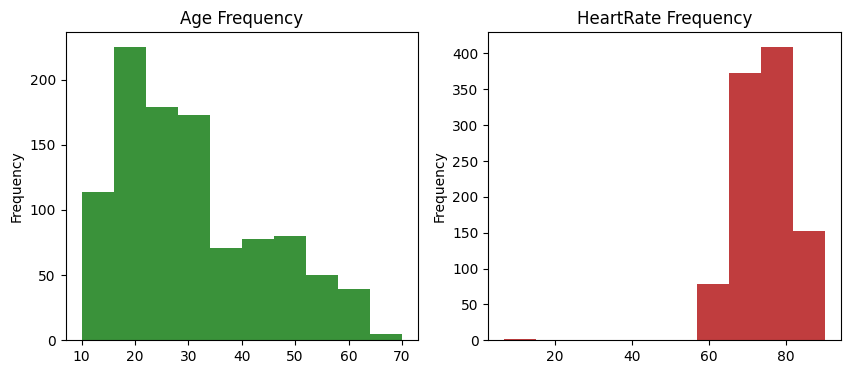

In [60]:
# Age and heart rate frequency
plt.subplots(1, 2, figsize = (10, 4))
plt.subplot(121)
df.Age.plot.hist(color = "#3a923a")
plt.title("Age Frequency");

plt.subplot(122) 
df.HeartRate.plot.hist(color = "#c03d3e")
plt.title("HeartRate Frequency");

The heart rate value "7" is definitely an outlier, most likely entered incorrectly. On the other hand most of the observations seem to be in the 20 - 30 age range. Then comes the 10 - 20 age range.

In [61]:
# A more detailed view to age distribution
px.box(df.Age, orientation = "h", points = "all")

The age value "70" can be considered an outlier, but "10" to "14" range is controversial. In fact, the discussion here indicates that the data set has real values: https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data/discussion/297518


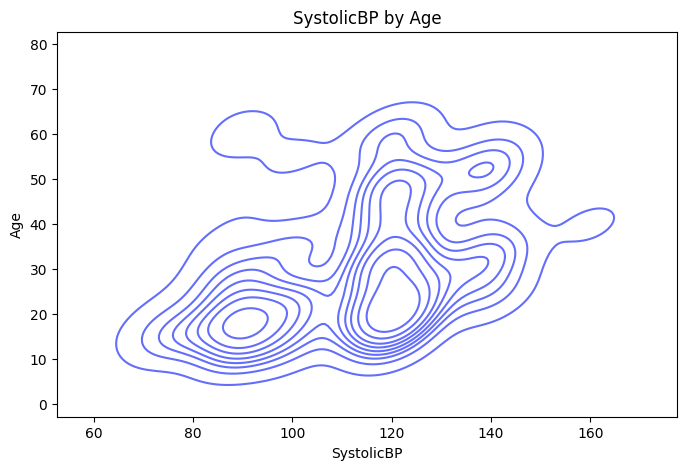

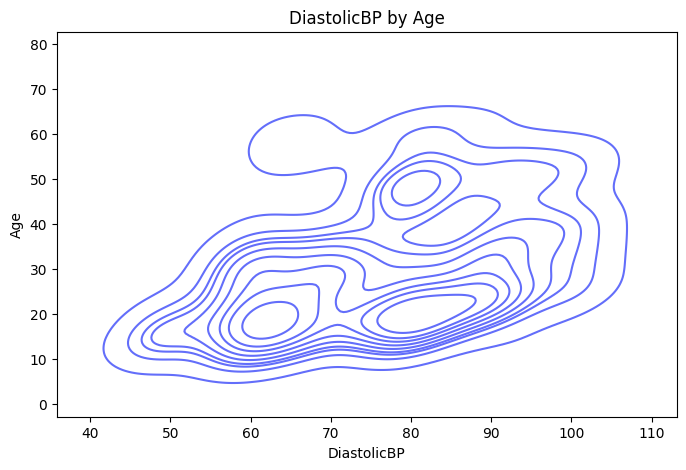

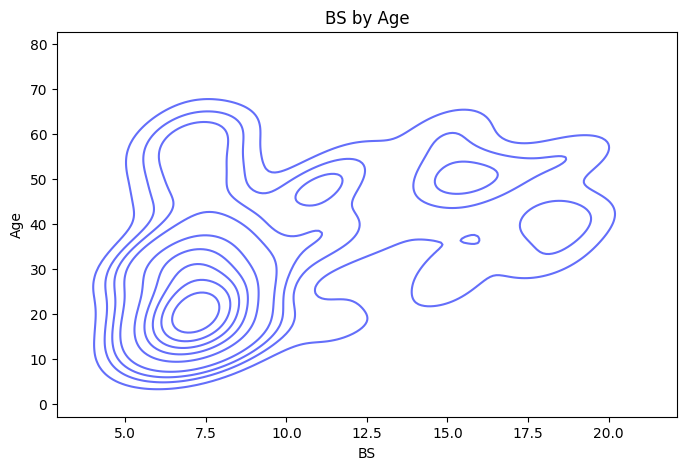

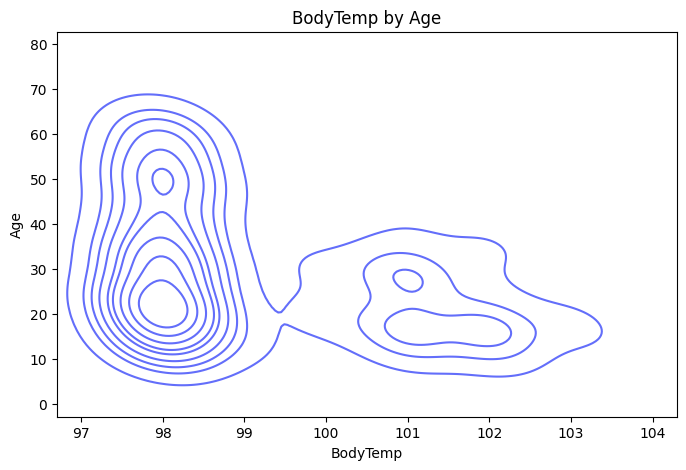

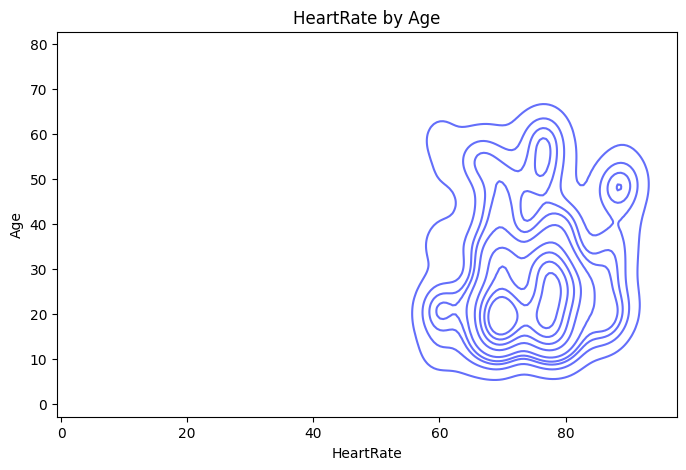

In [62]:
# Other feature distributions by age
columns = df.columns[1:6]
for i in range(len(columns)):
    plt.figure(figsize = (8, 5))
    sns.kdeplot(data = df, 
                x = columns[i], 
                y = "Age",
                color = "#636efa").set(title = f"{columns[i]} by Age");

#### **2.6.Distribution of features**

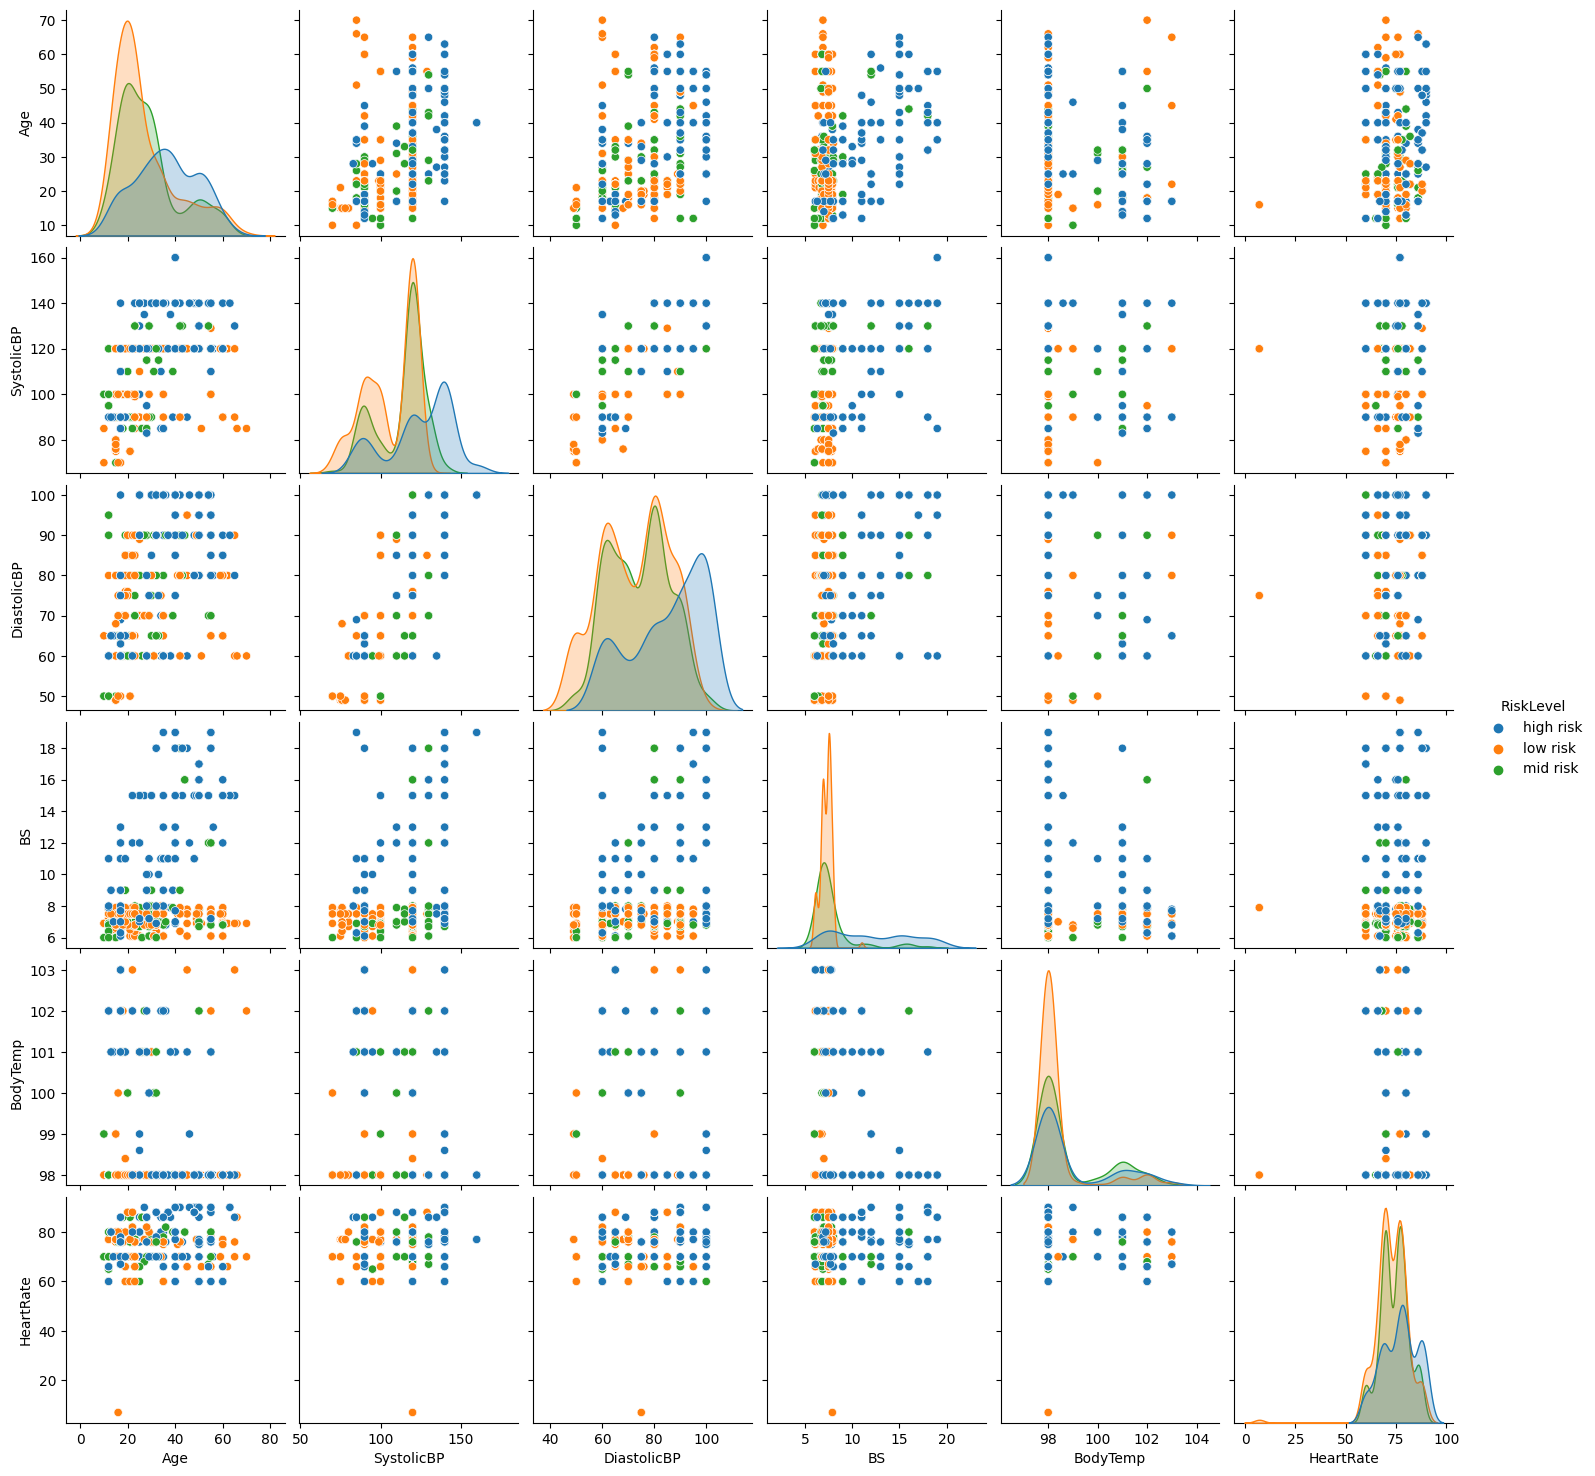

In [63]:
# General distribution
sns.pairplot(df.iloc[:,:], hue = "RiskLevel");

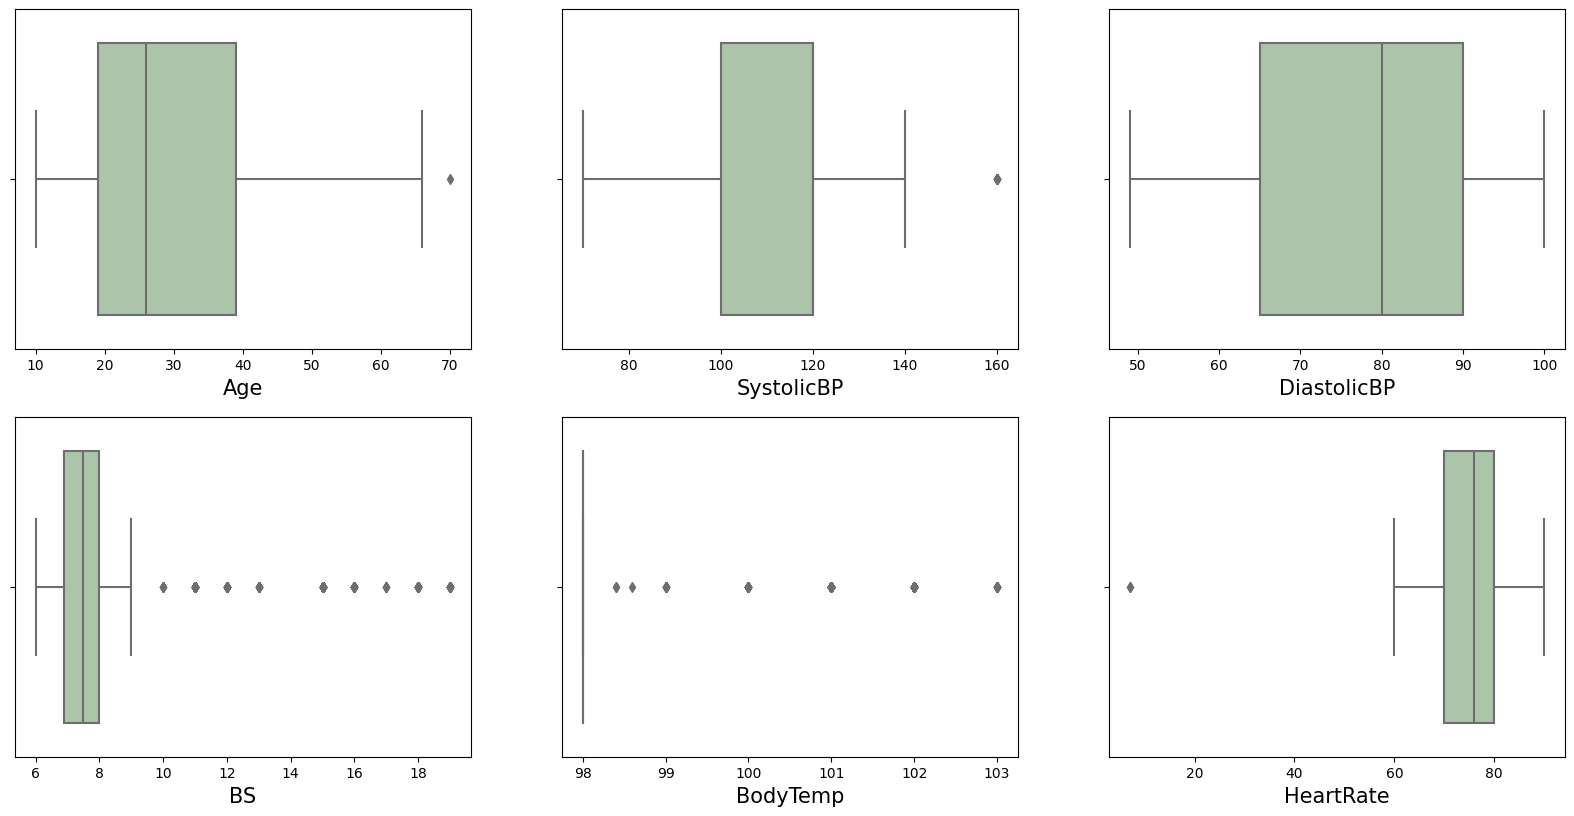

In [64]:
plt.figure(figsize = (20, 15))
for i, col in enumerate(df.iloc[:, 0:6]):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data = df.iloc[:, 0:6], x = col, color = "#a9c9a4")
    plt.xlabel(col, fontsize = 15)
    plt.xticks(fontsize = 10)

General age distribution on data set is in range 20-40. SystolicBP range 100-120, DiastolicBP range 60-90, BS range 7-8, HeartRate 70-80 and BodyTemp is mostly 98.

#### **2.7.Risk levels by features**

<Figure size 800x500 with 0 Axes>

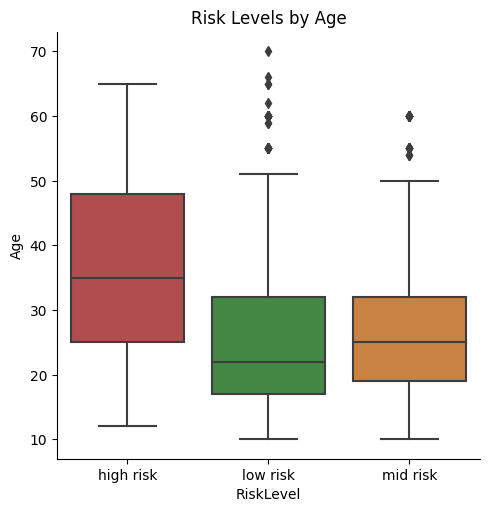

<Figure size 800x500 with 0 Axes>

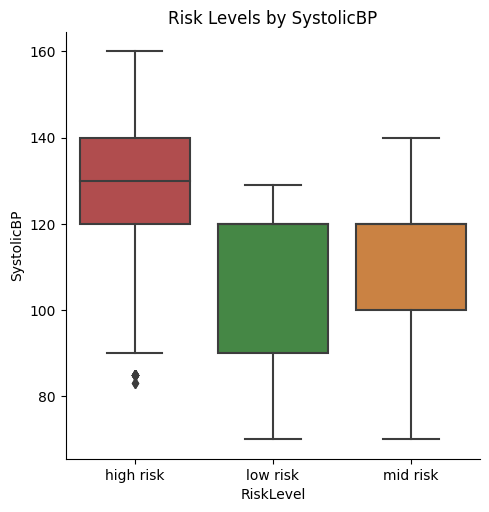

<Figure size 800x500 with 0 Axes>

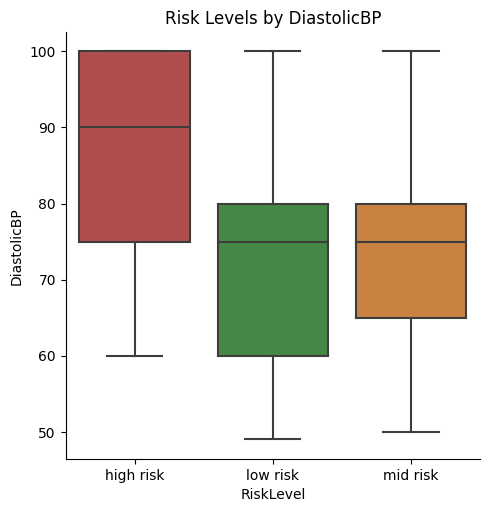

<Figure size 800x500 with 0 Axes>

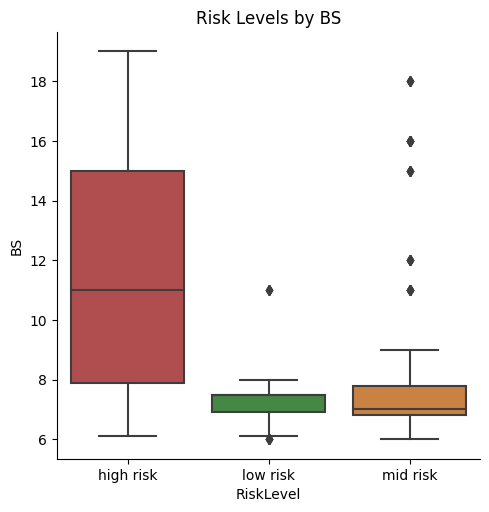

<Figure size 800x500 with 0 Axes>

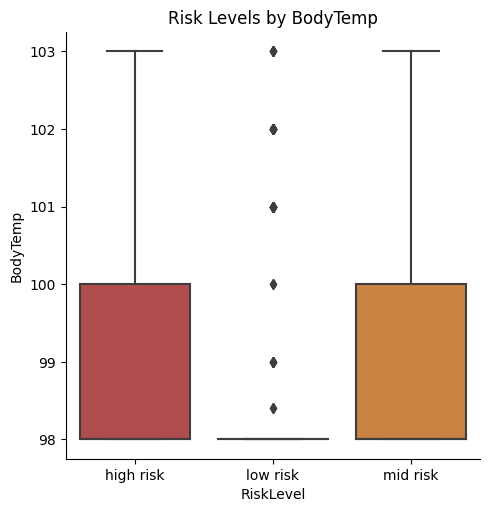

<Figure size 800x500 with 0 Axes>

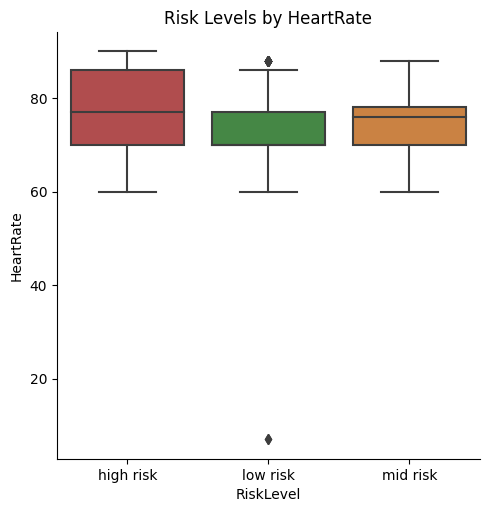

In [65]:
columns = df.columns[:len(df.columns) - 1]
for i in range(len(columns)):
    plt.figure(figsize = (8, 5))
    sns.catplot(data = df, 
                x = "RiskLevel", 
                y = columns[i], 
                kind = "box", 
                palette = ["#c03d3e","#3a923a","#e1812c"]).set(title = f"Risk Levels by {columns[i]}");

In general, it can be said that there is a linear relationship between features and risk levels. That means as feature values increase, the risk level also increases. Body temperature is an exception here because it breaks the pattern. Also there appear to be outliers in most features. We should deeply examine and handle them somehow.

#### **2.8.Encoding categorical features**

In [66]:
# "low risk": 0, 
# "mid risk": 1, 
# "high risk": 2
risk_map = {"low risk": 0, "mid risk": 1, "high risk": 2}
df["RiskLevel"] = df["RiskLevel"].map(risk_map)
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2
1012,43,120,90,18.0,98.0,70,2


#### **2.9.Correlations**

In [67]:
df.corr()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
Age,1.000000,0.416045,0.398026,0.473284,-0.255323,0.079798,0.267225
SystolicBP,0.416045,1.000000,0.787006,0.425172,-0.286616,-0.023108,0.396473
DiastolicBP,0.398026,0.787006,1.000000,0.423824,-0.257538,-0.046151,0.346649
BS,0.473284,0.425172,0.423824,1.000000,-0.103493,0.142867,0.569942
BodyTemp,-0.255323,-0.286616,-0.257538,-0.103493,1.000000,0.098771,0.163984
HeartRate,0.079798,-0.023108,-0.046151,0.142867,0.098771,1.000000,0.194312
RiskLevel,0.267225,0.396473,0.346649,0.569942,0.163984,0.194312,1.000000


(7.5, -0.5)

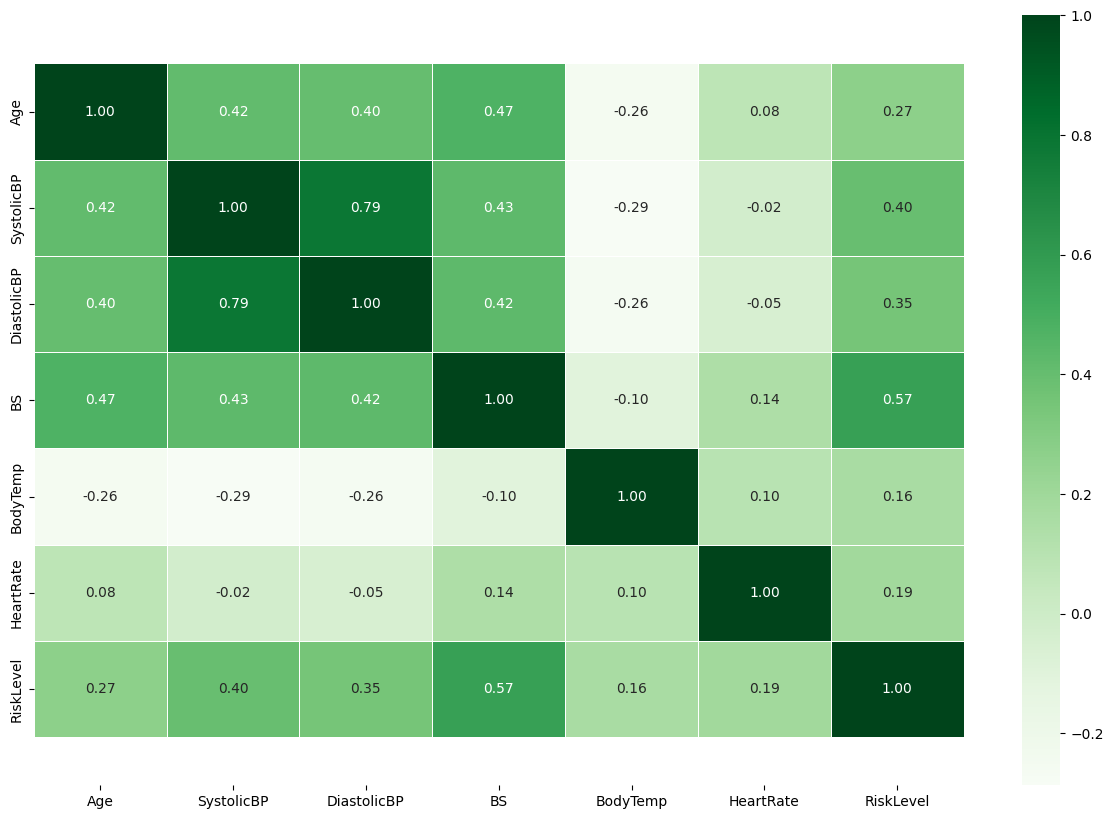

In [68]:
# Correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.heatmap(corr_matrix,
                 annot = True,
                 linewidths = 0.5,
                 fmt = ".2f",
                 cmap = "Greens");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

The correlation matrix tells that DiastolicBP and SystolicBP are highly correlated to each other. On the other hand blood pressure values and blood sugar are correlated to age. Also risk level depends mostly on blood sugar. Then comes blood pressure values and age. Heart rate and body temperature are least effective features on risk level here. Actually it is expected that age to be more decisive on the risk level, but the wide age distribution in the data set seems to reduce this effect.

#### **2.10.Detecting Outliers**

In [69]:
# Creating fence list
def createFenceList(df):
    feature_list = []
    q1_list = []
    q3_list = []
    iqr_list = []
    low_list = []
    up_list = []
    for col in df.columns:
        feature_list.append(col)
        q1 = df[col].quantile(0.25)
        q1_list.append(q1)
        q3 = df[col].quantile(0.75)
        q3_list.append(q3)
        iqr = q3 - q1
        iqr_list.append(iqr)

        lower_fence = q1 - (1.5 * iqr)
        low_list.append(lower_fence)
        upper_fence = q3 + (1.5 * iqr)
        up_list.append(upper_fence)
        
        list_of_lists = [q1_list, q3_list, iqr_list, low_list, up_list]
        fence_list = pd.DataFrame(list_of_lists, index = ["q1", "q2", "iqr", "lowerFence", "upperFence"],
                columns = feature_list)       
    return fence_list

In [70]:
createFenceList(df.iloc[:, 0:6])

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
q1,19.0,100.0,65.0,6.90,98.0,70.0
q2,39.0,120.0,90.0,8.00,98.0,80.0
iqr,20.0,20.0,25.0,1.10,0.0,10.0
lowerFence,-11.0,70.0,27.5,5.25,98.0,55.0
upperFence,69.0,150.0,127.5,9.65,98.0,95.0


In [71]:
# How many outliers of each feature?
def detectOutliers(df):
    outliers = pd.DataFrame(columns = ["Feature", "Number of Outliers"])
    features = []
    numbers = []
    for col in df.columns:
        features.append(col)
        #Return values at the given quantile
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_fence = q1 - (1.5 * iqr)
        upper_fence = q3 + (1.5 * iqr)
        num_of_out = df.loc[(df[col] < lower_fence) | (df[col] > upper_fence)].shape[0]
        numbers.append(num_of_out)

        lower_fence = df.loc[(df[col] < lower_fence), col]
        upper_fence = df.loc[(df[col] > upper_fence), col] 

    outliers["Feature"] = features
    outliers["Number of Outliers"] = numbers
    
    print("Total number of outliers:", outliers["Number of Outliers"].sum())
    print("Percentage of outliers: % {:.3f}".format(outliers["Number of Outliers"].sum()/df.shape[0]))
    return outliers  

In [72]:
detectOutliers(df.iloc[:, 0:6])

Total number of outliers: 433
Percentage of outliers: % 0.427


,Feature,Number of Outliers
0,Age,1
1,SystolicBP,10
2,DiastolicBP,0
3,BS,210
4,BodyTemp,210
5,HeartRate,2


There are so many outliers in data set. We want to examine them more detailed.

<Figure size 800x500 with 0 Axes>

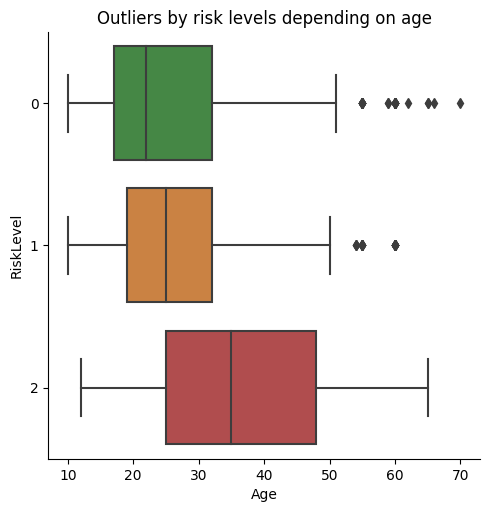

In [73]:
# Outliers by risk levels depending on age
plt.figure(figsize = (8, 5))
sns.catplot(data = df, 
            x = "Age", 
            y = "RiskLevel",
            kind = "box", 
            palette = ["#3a923a", "#e1812c", "#c03d3e"],
            orient = "h").set(title = "Outliers by risk levels depending on age");

In [74]:
print("\033[1m" + "Low Risk by Age > 50: ", ((df["Age"] > 50) & (df["RiskLevel"] == 0)).sum())
print("\033[1m" + "Mid Risk by Age > 50: ", ((df["Age"] > 50) & (df["RiskLevel"] == 1)).sum())
print("\033[0m" + "High Risk by Age > 50: ", ((df["Age"] > 50) & (df["RiskLevel"] == 2)).sum())

Low Risk by Age > 50:  33
Mid Risk by Age > 50:  25
High Risk by Age > 50:  37


<Figure size 800x500 with 0 Axes>

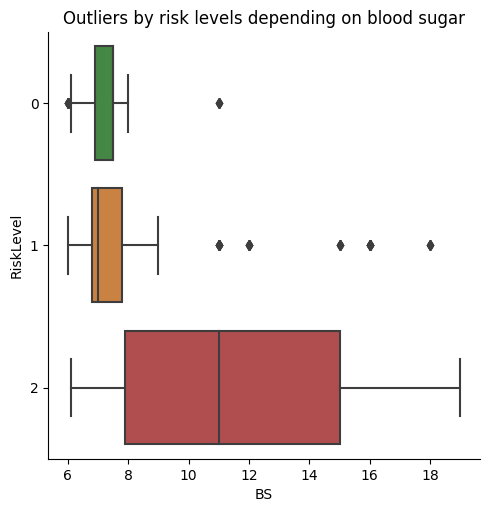

In [75]:
# Outliers by risk levels depending on blood sugar
plt.figure(figsize = (8, 5))
sns.catplot(data = df, 
            x = "BS", 
            y = "RiskLevel",
            kind = "box", 
            palette = ["#3a923a", "#e1812c", "#c03d3e"],
            orient = "h").set(title = "Outliers by risk levels depending on blood sugar");

In [76]:
print("\033[1m" + "Low Risk by BS > 10: ", ((df["BS"] > 10) & (df["RiskLevel"] == 0)).sum())
print("\033[1m" + "Mid Risk by BS > 10: ", ((df["BS"] > 10) & (df["RiskLevel"] == 1)).sum())
print("\033[0m" + "High Risk by BS > 10: ", ((df["BS"] > 10) & (df["RiskLevel"] == 2)).sum())

Low Risk by BS > 10:  4
Mid Risk by BS > 10:  32
High Risk by BS > 10:  170


<Figure size 800x500 with 0 Axes>

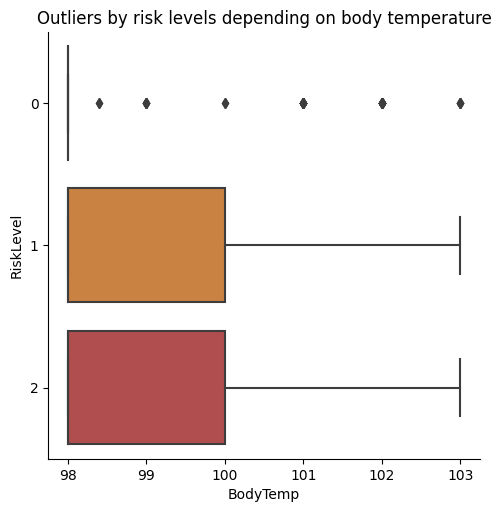

In [77]:
# Outliers by risk levels depending on body temperature
plt.figure(figsize = (8, 5))
sns.catplot(data = df, 
            x = "BodyTemp", 
            y = "RiskLevel",
            kind = "box", 
            palette = ["#3a923a", "#e1812c", "#c03d3e"],
            orient = "h").set(title = "Outliers by risk levels depending on body temperature");

In [78]:
print("\033[1m" + "Low Risk by BodyTemp > 100: ", ((df["BodyTemp"] > 100) & (df["RiskLevel"] == 0)).sum())
print("\033[0m" + "Mid Risk by BodyTemp > 100: ", ((df["BodyTemp"] > 100) & (df["RiskLevel"] == 1)).sum())
print("\033[0m" + "High Risk by BodyTemp > 100: ", ((df["BodyTemp"] > 100) & (df["RiskLevel"] == 2)).sum())

Low Risk by BodyTemp > 100:  37
Mid Risk by BodyTemp > 100:  75
High Risk by BodyTemp > 100:  65


Besides we determined the upper fence of age as 50 because a quick google search (just one of examples: https://en.wikipedia.org/wiki/Pregnancy_over_age_50) shows that pregnancies over age 50 are very unlikely and considered exceptional. So, we can consider them as outliers. Likewise, blood sugar over 10-11 considered as diabetes and body temperature over 100.4 considered as high fever. It is expected that these ilnesses increase risk levels. But we can't observe their effects on risk levels above. So, we consider them as outliers, too. We determined heart rate "7" as outlier before. Now we can get rid of the outliers with peace of mind. :)

# **3.Data preprocessing**

#### **3.1.Removing Outliers**

In [79]:
df = df[~((df["BodyTemp"] > 100) & (df["RiskLevel"] == 0) )]
df = df[~((df["BS"] > 10) & (df["RiskLevel"] == 0) | (df["BS"] > 10) & (df["RiskLevel"] == 1))]
df = df[~((df["Age"] > 50) & (df["RiskLevel"] == 0) | (df["Age"] > 50) & (df["RiskLevel"] == 1))]
df = df[~(df["HeartRate"] < 55)]
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2
1012,43,120,90,18.0,98.0,70,2


Now there are 895 observations without outliers. Let's have look risk level distributions one more time.

In [80]:
# Risk level counts
risk_levels = df["RiskLevel"].value_counts()
risk_levels_df = pd.DataFrame(risk_levels)
risk_levels_df = risk_levels.reset_index(level = 0)
risk_levels_df

,RiskLevel,count
0,0,333
1,1,290
2,2,272


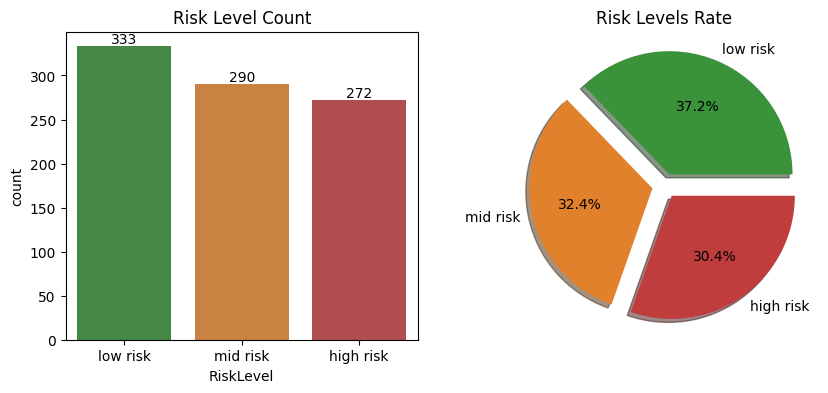

In [81]:
# Plotting risk level counts and rates
cmap = ["#3a923a","#e1812c","#c03d3e","#3274a1","#857aab","#8d7866"]

plt.subplots(1, 2, figsize = (10, 4))
plt.subplot(121)
ax = sns.barplot(data = risk_levels_df, 
                 x = risk_levels_df["RiskLevel"], 
                 y = risk_levels_df["count"],
                 palette = cmap)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(["low risk", "mid risk", "high risk"])
plt.title("Risk Level Count");

plt.subplot(122) 
plt.pie(x = risk_levels, 
        explode = [0.1, 0.1, 0.1],
        labels = ["low risk", "mid risk", "high risk"],
        colors = cmap,
        autopct = "%.1f%%", 
        shadow = True)
plt.title("Risk Levels Rate");

Now we have data set that have more balanced distribution.

#### **3.2.Splitting**

In [82]:
# Split data into features and target
X = df.drop(["RiskLevel"], axis = 1)
y = df["RiskLevel"]

In [83]:
X

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,25,130,80,15.0,98.0,86
1,35,140,90,13.0,98.0,70
2,29,90,70,8.0,100.0,80
3,30,140,85,7.0,98.0,70
4,35,120,60,6.1,98.0,76
...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80
1010,55,120,90,18.0,98.0,60
1011,35,85,60,19.0,98.0,86
1012,43,120,90,18.0,98.0,70


In [84]:
y

0       2
1       2
2       2
3       2
4       0
       ..
1009    2
1010    2
1011    2
1012    2
1013    1
Name: RiskLevel, Length: 895, dtype: int64

In [85]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = seed)

#### **3.3.Standardization**

In [86]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_trainStandart = scaler.transform(X_train)
X_testStandart = scaler.transform(X_test)

In [87]:
X_trainStandart, len(X_trainStandart)

(array([[-0.30136064,  0.32294202,  0.91464163, -0.59705876,  1.94099147,
          0.72194873],
        [-0.4741978 ,  0.32294202,  0.91464163, -0.26472668, -0.45557788,
         -1.91788717],
        [-0.64703496,  0.32294202,  0.20689669, -0.53663474, -0.45557788,
          0.19398155],
        ...,
        [ 0.30356942,  1.41246886,  1.62238658, -0.23451467, -0.45557788,
          0.45796514],
        [-0.73345354, -0.76658482,  0.91464163, -0.50642273, -0.45557788,
          1.77788309],
        [-0.81987212,  0.32294202,  0.20689669, -0.50642273, -0.45557788,
         -0.59796922]]),
 626)

In [88]:
X_testStandart, len(X_testStandart)

(array([[-1.3383836 , -1.31134824, -0.85472073,  0.09781741,  1.94099147,
          0.72194873],
        [-0.73345354,  0.32294202, -0.14697579, -0.3553627 , -0.45557788,
         -0.59796922],
        [ 0.73566232,  0.32294202,  0.91464163,  0.70205755, -0.45557788,
          1.77788309],
        ...,
        [-0.30136064,  0.32294202,  0.20689669, -0.50642273, -0.45557788,
         -1.1259364 ],
        [-1.42480218, -1.31134824, -1.20859321,  0.70205755,  2.73984791,
         -1.91788717],
        [-0.4741978 ,  0.32294202,  0.91464163, -0.29493869, -0.45557788,
         -1.91788717]]),
 269)

# **4.Modelling**

In [89]:
# Classifier comparison with default parameters
scoresCV = []
classifiers = [SVC(random_state = seed),
               XGBClassifier(random_state = seed)
              ]
for classifier in classifiers:
    pipe = make_pipeline(preprocessing.StandardScaler(), classifier)
    scoreCV = cross_val_score(pipe, 
                              X_train, 
                              y_train, 
                              scoring = "accuracy", 
                              cv = StratifiedKFold(n_splits = 5, 
                                                   shuffle = True,
                                                   random_state = seed))
    scoresCV.append([classifier, np.mean(scoreCV)])

In [90]:
# Best classifiers according to validation accuracy descending
c_val = pd.DataFrame(scoresCV, columns=["Classifier", "Validation Accuracy"])
c_val_sort = c_val.sort_values(by = "Validation Accuracy", ignore_index = True)
c_val_sort

,Classifier,Validation Accuracy
0,SVC(random_state=20),0.746019
1,"XGBClassifier(base_score=None, booster=None, c...",0.840254


#### **4.1.SVM Model**

##### **4.1.1.Parameter Tuning**

In [91]:
# Creating model pipeline
pipe = Pipeline([("scaler", preprocessing.StandardScaler()),
                 ("Classifier", SVC(random_state = seed))])
# Searching parameters
params = [{"Classifier__kernel": ["rbf", "linear"], 
           "Classifier__gamma": [1, 0.1, 0.01, 0.001],
           "Classifier__C": [1, 10, 100, 1000]}
         ]
# Creating grid
svc_clf_grid = RandomizedSearchCV(estimator = pipe, 
                                  param_distributions = params,
                                  cv = StratifiedKFold(n_splits = 10, 
                                                       shuffle = True,
                                                       random_state = seed),
                                  n_iter = 10,
                                  verbose = 2, 
                                  scoring = "accuracy",
                                  n_jobs = -1)
# Fit the model
svc_model = svc_clf_grid.fit(X_trainStandart, y_train)

# Get best parameters
print("Best parameters for SVC model: ", svc_model.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for SVC model:  {'Classifier__kernel': 'rbf', 'Classifier__gamma': 1, 'Classifier__C': 100}


In [92]:
# Best parameters
svc_best = pd.DataFrame.from_dict(svc_model.best_params_, orient = "index").rename(columns = {0: "Best"})
svc_best

,Best
Classifier__kernel,rbf
Classifier__gamma,1
Classifier__C,100


##### **4.2.2.Building model with best parameters**

In [93]:
svc_clf = SVC(kernel = svc_best.iloc[0,0], 
              gamma = float(svc_best.iloc[1,0]),
              C = float(svc_best.iloc[2,0]),
              random_state = seed,
              probability = True)
# Fit the model
svc_clf.fit(X_trainStandart, y_train)

SVC(C=100.0, gamma=1.0, probability=True, random_state=20)

##### **4.2.3.Predictions and model accuracy**

In [94]:
svc_model = svc_clf.fit(X_trainStandart, y_train)
svc_pred = svc_clf.predict(X_testStandart)
svc_acc = accuracy_score(y_test, svc_pred)
print("SVC Model Accuracy:", svc_acc)
svc_acc_tr = svc_clf.score(X_trainStandart, y_train)


SVC Model Accuracy: 0.7992565055762082


##### **4.2.4.Other test parameters**

In [95]:
# Classification Report
print("SVC Classification Report\n\n", classification_report(y_test, svc_pred))

SVC Classification Report

               precision    recall  f1-score   support

           0       0.78      0.76      0.77       100
           1       0.70      0.75      0.72        87
           2       0.94      0.90      0.92        82

    accuracy                           0.80       269
   macro avg       0.81      0.80      0.80       269
weighted avg       0.80      0.80      0.80       269



In [96]:
#  For comparison list records
svc_recall = recall_score(y_test, svc_pred, average = None)
svc_prec = precision_score(y_test, svc_pred, average = None)
svc_f1 = f1_score(y_test, svc_pred, average = None)

SVC Confusion Matrix


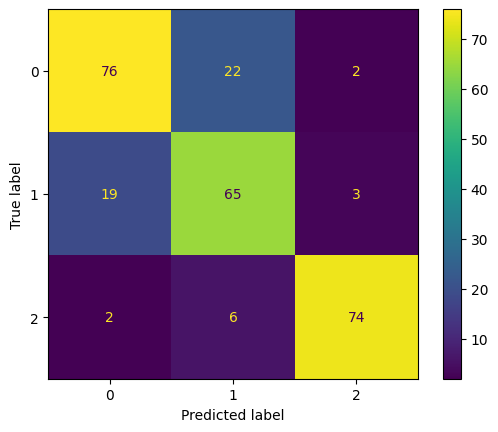

In [97]:
# Confusion matrix
svc_cm = confusion_matrix(y_test, svc_pred, labels = svc_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = svc_cm,
                              display_labels = svc_clf.classes_)
print("SVC Confusion Matrix")
disp.plot()
plt.show();

In [98]:
# Prediction rates
def calculatePredictionRates(model_name, accuracy, confusion_matrix):
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(confusion_matrix)
calculatePredictionRates("SVC", svc_acc, svc_cm)

Model: SVC
Accuracy: 0.7992565055762082
Confusion Matrix:
[[76 22  2]
 [19 65  3]
 [ 2  6 74]]


In [99]:
# Train/Test Performance Metrics
def calculatePerformance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    return train_accuracy, test_accuracy

svc_pm = pd.DataFrame(calculatePerformance(svc_clf, X_trainStandart, y_train, X_testStandart, y_test))*100
svc_pm

,0
0,90.894569
1,79.925651


In [100]:
# Updating comparison lists
# Define and initialize lists to store model performance data
model_name_list = []
model_list = []
predictions_list = []
accuracy_list = []
confusion_matrix_list = []
f1_score_list = []
performance_metrics_list = []
precision_list = []
recall_list = []
train_accuracy_list = []

# Define the updateLists function
def updateLists(model_name, model, predictions, accuracy, confusion_matrix, f1_score, performance_metrics, precision, recall, train_accuracy):
    model_name_list.append(model_name)
    model_list.append(model)
    predictions_list.append(predictions)
    accuracy_list.append(accuracy)
    confusion_matrix_list.append(confusion_matrix)
    f1_score_list.append(f1_score)
    performance_metrics_list.append(performance_metrics)
    precision_list.append(precision)
    recall_list.append(recall)
    train_accuracy_list.append(train_accuracy)

# Now you can call the updateLists function
updateLists("SVC", svc_clf, svc_pred, svc_acc, svc_cm, svc_f1, svc_pm, svc_prec, svc_recall, svc_acc_tr)



#### **4.5.XGB Classifier**

##### **4.5.1.Parameter Tuning**

In [101]:
# Creating model
clf = XGBClassifier(random_state = seed)
# Searching parameters
params = {"n_estimators": [50, 100, 500, 1000],
          "learning_rate": [1, 0.1, 0.01, 0.001],
          "gamma": [1, 0.1, 0.01, 0.001]
         }
# Creating grid
xg_clf_grid = RandomizedSearchCV(estimator = clf, 
                                 param_distributions = params,
                                 cv = StratifiedKFold(n_splits = 10, 
                                                      shuffle = True,
                                                      random_state = seed),
                                 n_iter = 10,
                                 verbose = 2, 
                                 scoring = "accuracy",
                                 n_jobs = -1)
# Fit the model
xg_model = xg_clf_grid.fit(X_train, y_train)

# Get best parameters
print("Best parameters for XGB model: ", xg_model.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END Classifier__C=100, Classifier__gamma=0.01, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=100, Classifier__gamma=0.01, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=100, Classifier__gamma=0.01, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=100, Classifier__gamma=0.01, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=1000, Classifier__gamma=0.001, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=1000, Classifier__gamma=0.001, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=1000, Classifier__gamma=0.001, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=10, Classifier__gamma=1, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=10, Classifier__gamma=1, Classifier__kernel=rbf; total time=   0.0s
[CV] END Classifier__C=1000, Classifier__gamma=0.1, Classifier__kernel=linear; total

In [102]:
# Best parameters
xg_best = pd.DataFrame.from_dict(xg_model.best_params_, orient = "index").rename(columns = {0: "Best"})
xg_best

,Best
n_estimators,50.00
learning_rate,1.00
gamma,0.01


##### **4.5.2.Building model with best parameters**

In [103]:
xg_clf = XGBClassifier(n_estimators = int(xg_best.iloc[0,0]), 
                       learning_rate = float(xg_best.iloc[1,0]),
                       gamma = float(xg_best.iloc[2,0]),
                       random_state = seed)
# Fit the model
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

##### **4.5.3.Predictions and model accuracy**

In [104]:
xg_pred = xg_clf.predict(X_test)
xg_acc = accuracy_score(y_test, xg_pred)
print("XGB Model Accuracy:", xg_acc)
xg_acc_tr = xg_clf.score(X_train, y_train)

XGB Model Accuracy: 0.862453531598513


##### **4.5.4.Other test parameters**

In [105]:
# Classification Report
print("XGB Classification Report\n\n", classification_report(y_test, xg_pred))

XGB Classification Report

               precision    recall  f1-score   support

           0       0.89      0.83      0.86       100
           1       0.78      0.85      0.81        87
           2       0.93      0.91      0.92        82

    accuracy                           0.86       269
   macro avg       0.87      0.87      0.86       269
weighted avg       0.87      0.86      0.86       269



In [106]:
# For comparison list records
xg_recall = recall_score(y_test, xg_pred, average = None)
xg_prec = precision_score(y_test, xg_pred, average = None)
xg_f1 = f1_score(y_test, xg_pred, average = None)

XGB Confusion Matrix


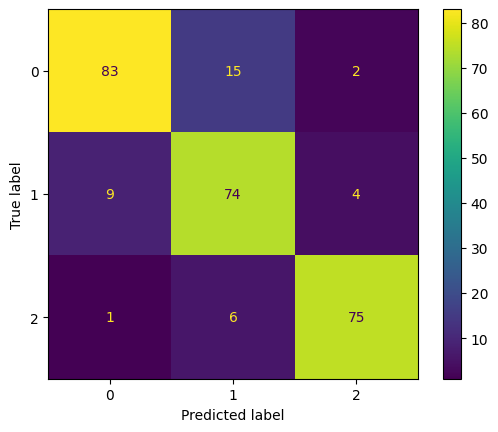

In [107]:
# Confusion matrix
xg_cm = confusion_matrix(y_test, xg_pred, labels = xg_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = xg_cm,
                              display_labels = xg_clf.classes_)
print("XGB Confusion Matrix")
disp.plot()
plt.show();

In [108]:
# Prediction rates
calculatePredictionRates("XGB", xg_acc, xg_cm)

Model: XGB
Accuracy: 0.862453531598513
Confusion Matrix:
[[83 15  2]
 [ 9 74  4]
 [ 1  6 75]]


In [109]:
# Train/Test Performance Metrics
xg_pm = pd.DataFrame(calculatePerformance(xg_clf, X_train, y_train, X_test, y_test))*100
xg_pm

,0
0,94.249201
1,86.245353


In [110]:
# Updating comparison lists
updateLists("XGB", xg_clf, xg_pred, xg_acc, xg_cm, xg_f1, xg_pm, xg_prec, xg_recall, xg_acc_tr)

##### **4.5.5.Feature Importances**

In [111]:
# Ploting the impurity-based feature importances
feats = {} # a dictionary to hold feature_name: feature_importance
importances = xg_clf.feature_importances_
xg_clf.feature_importances_

array([0.04914801, 0.24326397, 0.04777365, 0.22432782, 0.39143512,
       0.04405137], dtype=float32)

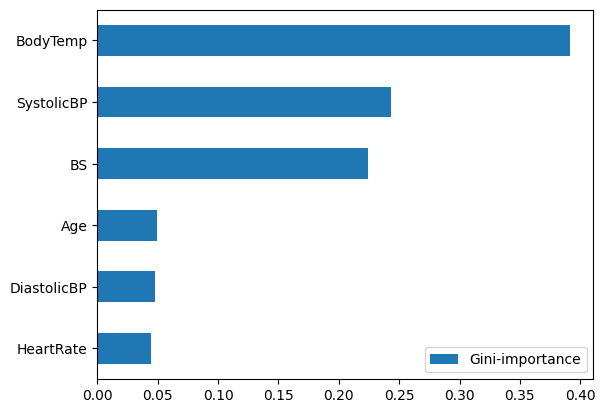

In [112]:
for feature, importance in zip(X.columns, xg_clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient = "index").rename(columns = {0: "Gini-importance"})
importances = importances.sort_values(by = "Gini-importance")
importances.plot.barh();

In [113]:
# Model creation
dl_clf = keras.Sequential()
# Layers
dl_clf.add(layers.Dense(128, activation = "relu", input_shape = (X_trainStandart.shape[1], ) ))
dl_clf.add(layers.Dense(64, activation = "relu"))
dl_clf.add(layers.Dense(3, activation = "softmax"))
# Compile
dl_clf.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
# Training
dl_hist = dl_clf.fit(X_trainStandart, 
                     y_train, 
                     validation_data = (X_testStandart, y_test),
                     epochs = 100)

Epoch 1/100
20/20 [==============================] - 1s 16ms/step - loss: 0.9306 - accuracy: 0.5687 - val_loss: 0.7910 - val_accuracy: 0.6320
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7259 - accuracy: 0.6645 - val_loss: 0.6814 - val_accuracy: 0.6989
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.7077 - val_loss: 0.6224 - val_accuracy: 0.6877
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5908 - accuracy: 0.7173 - val_loss: 0.5847 - val_accuracy: 0.6989
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5572 - accuracy: 0.7204 - val_loss: 0.5584 - val_accuracy: 0.7175
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5384 - accuracy: 0.7332 - val_loss: 0.5434 - val_accuracy: 0.7175
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5178 - accuracy: 0.7412 - val_loss: 0.5297 - val_accuracy: 0.7175
Epoch 8/100


##### **4.6.2.Predictions and model accuracy**

In [114]:
dl_pred_proba = dl_clf.predict(X_testStandart) #probabilities
dl_pred = (dl_pred_proba > 0.5).astype("int") #one-hot encoded
dl_acc = dl_clf.evaluate(X_testStandart, y_test)[1]
print("Deep Learning Model Accuracy:", dl_acc)
dl_acc_tr = dl_clf.evaluate(X_trainStandart, y_train)[1]
print("Deep Learning Training Accuracy:", dl_acc_tr)

9/9 [==============================] - 0s 2ms/step - loss: 0.4718 - accuracy: 0.8141
Deep Learning Model Accuracy: 0.8141263723373413
20/20 [==============================] - 0s 2ms/step - loss: 0.3019 - accuracy: 0.8722
Deep Learning Training Accuracy: 0.8722044825553894


##### **4.6.3.Other test parameters**

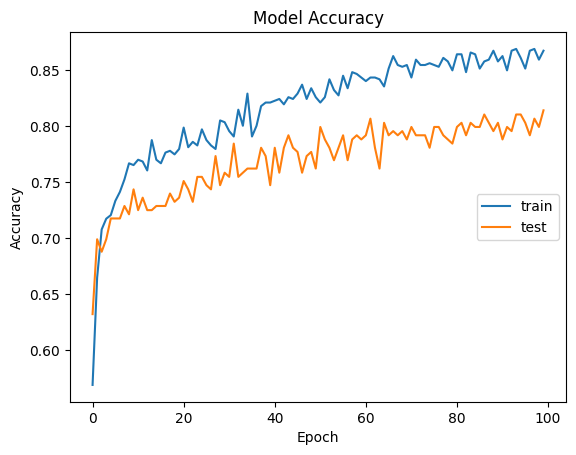

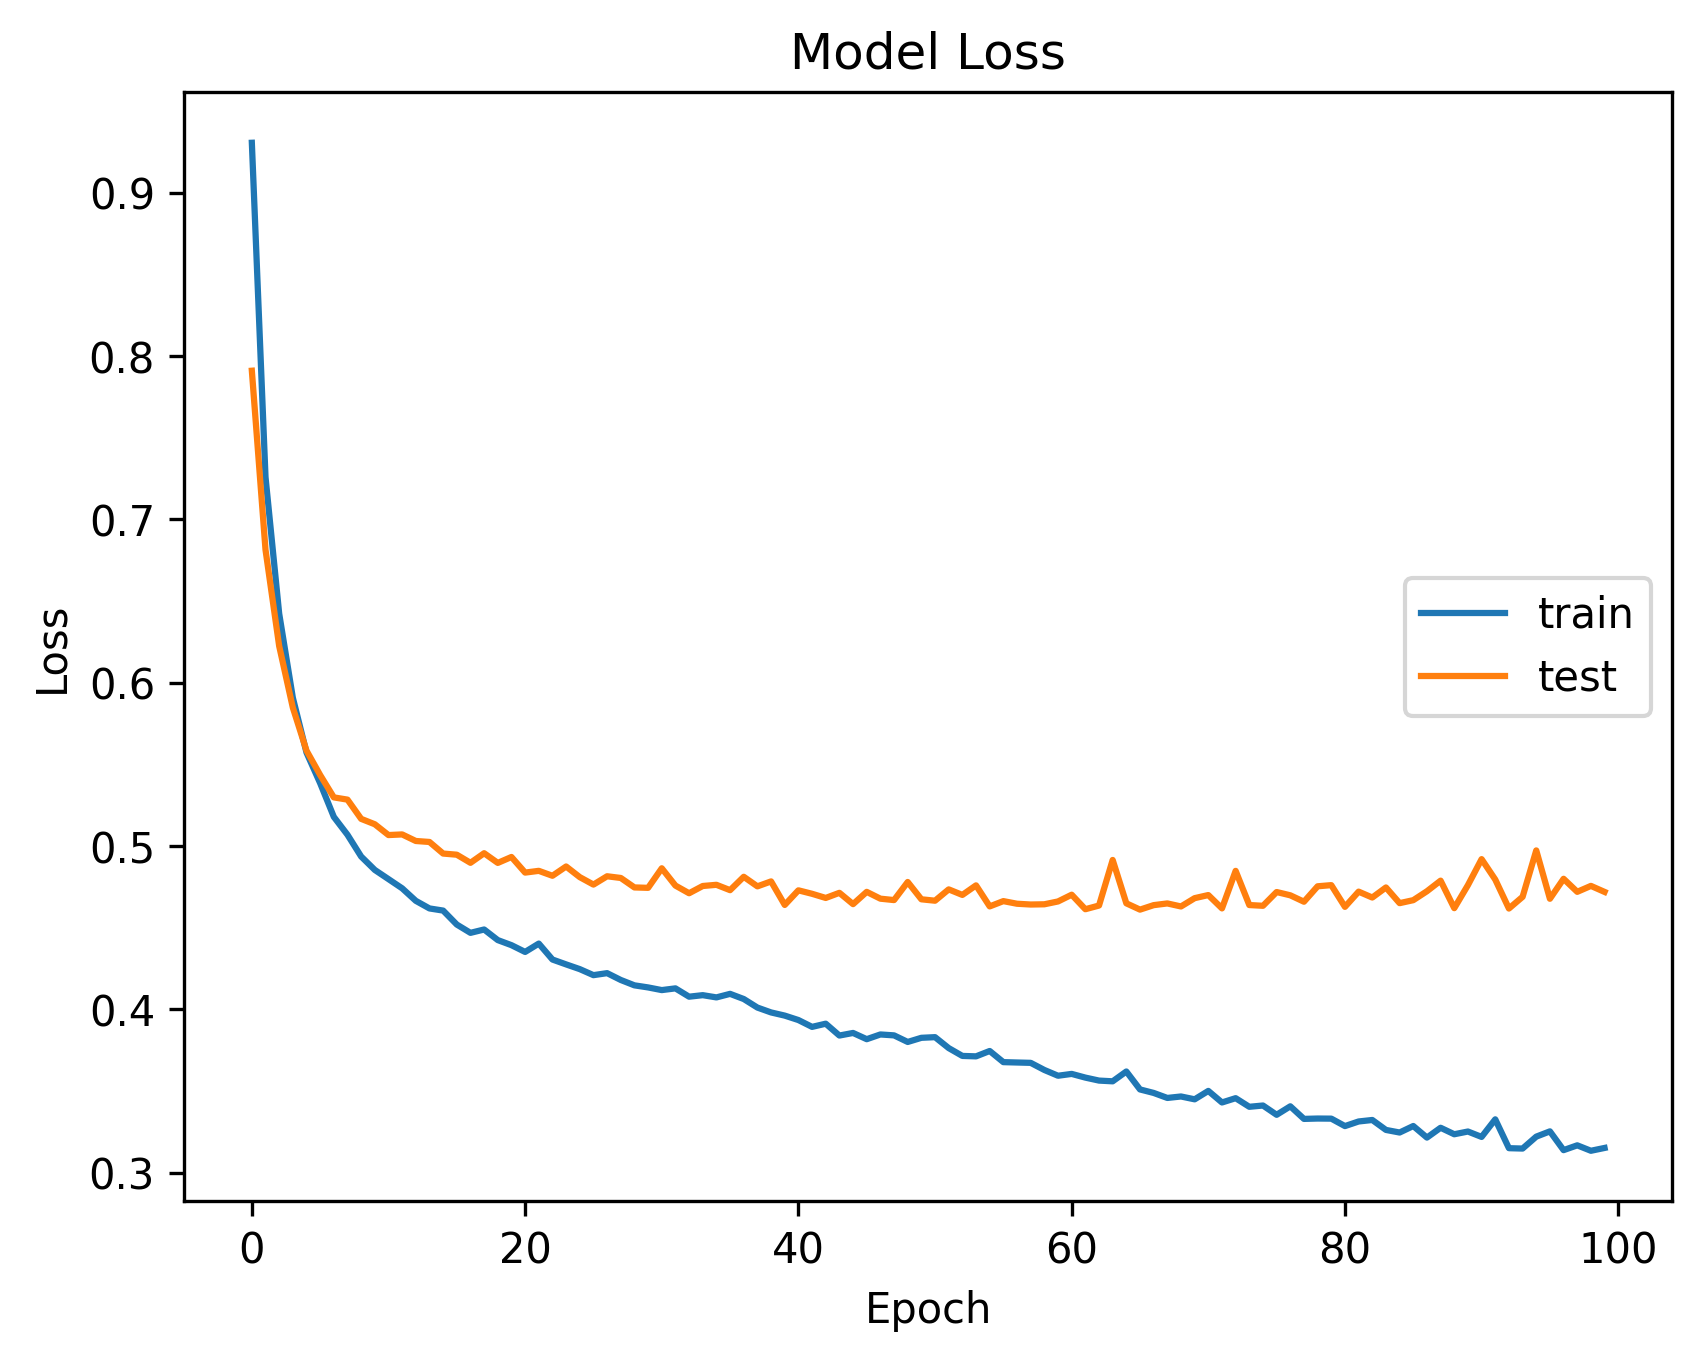

In [115]:
# Model metrics history
plt.plot(dl_hist.history['accuracy'])
plt.plot(dl_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'center right')
plt.rcParams['figure.dpi'] = 300
plt.show()
        
plt.plot(dl_hist.history['loss'])
plt.plot(dl_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'center right')
plt.rcParams['figure.dpi'] = 300
plt.show()

In [116]:
# For getting classification parameters we have to convert one-hot encoded dl_pred to single-digits
dl_pred_arg = np.argmax(dl_clf.predict(X_testStandart), axis = 1) 

9/9 [==============================] - 0s 2ms/step


In [117]:
# Classification Report
print("Deep Learning Classification Report\n\n", classification_report(y_test, dl_pred_arg))

Deep Learning Classification Report

               precision    recall  f1-score   support

           0       0.77      0.86      0.81       100
           1       0.74      0.67      0.70        87
           2       0.95      0.91      0.93        82

    accuracy                           0.81       269
   macro avg       0.82      0.81      0.82       269
weighted avg       0.82      0.81      0.81       269



In [118]:
# For comparison list recordings
dl_recall = recall_score(y_test, dl_pred_arg, average = None)
dl_prec = precision_score(y_test, dl_pred_arg, average = None)
dl_f1 = f1_score(y_test, dl_pred_arg, average = None)

Deep Learning Confusion Matrix


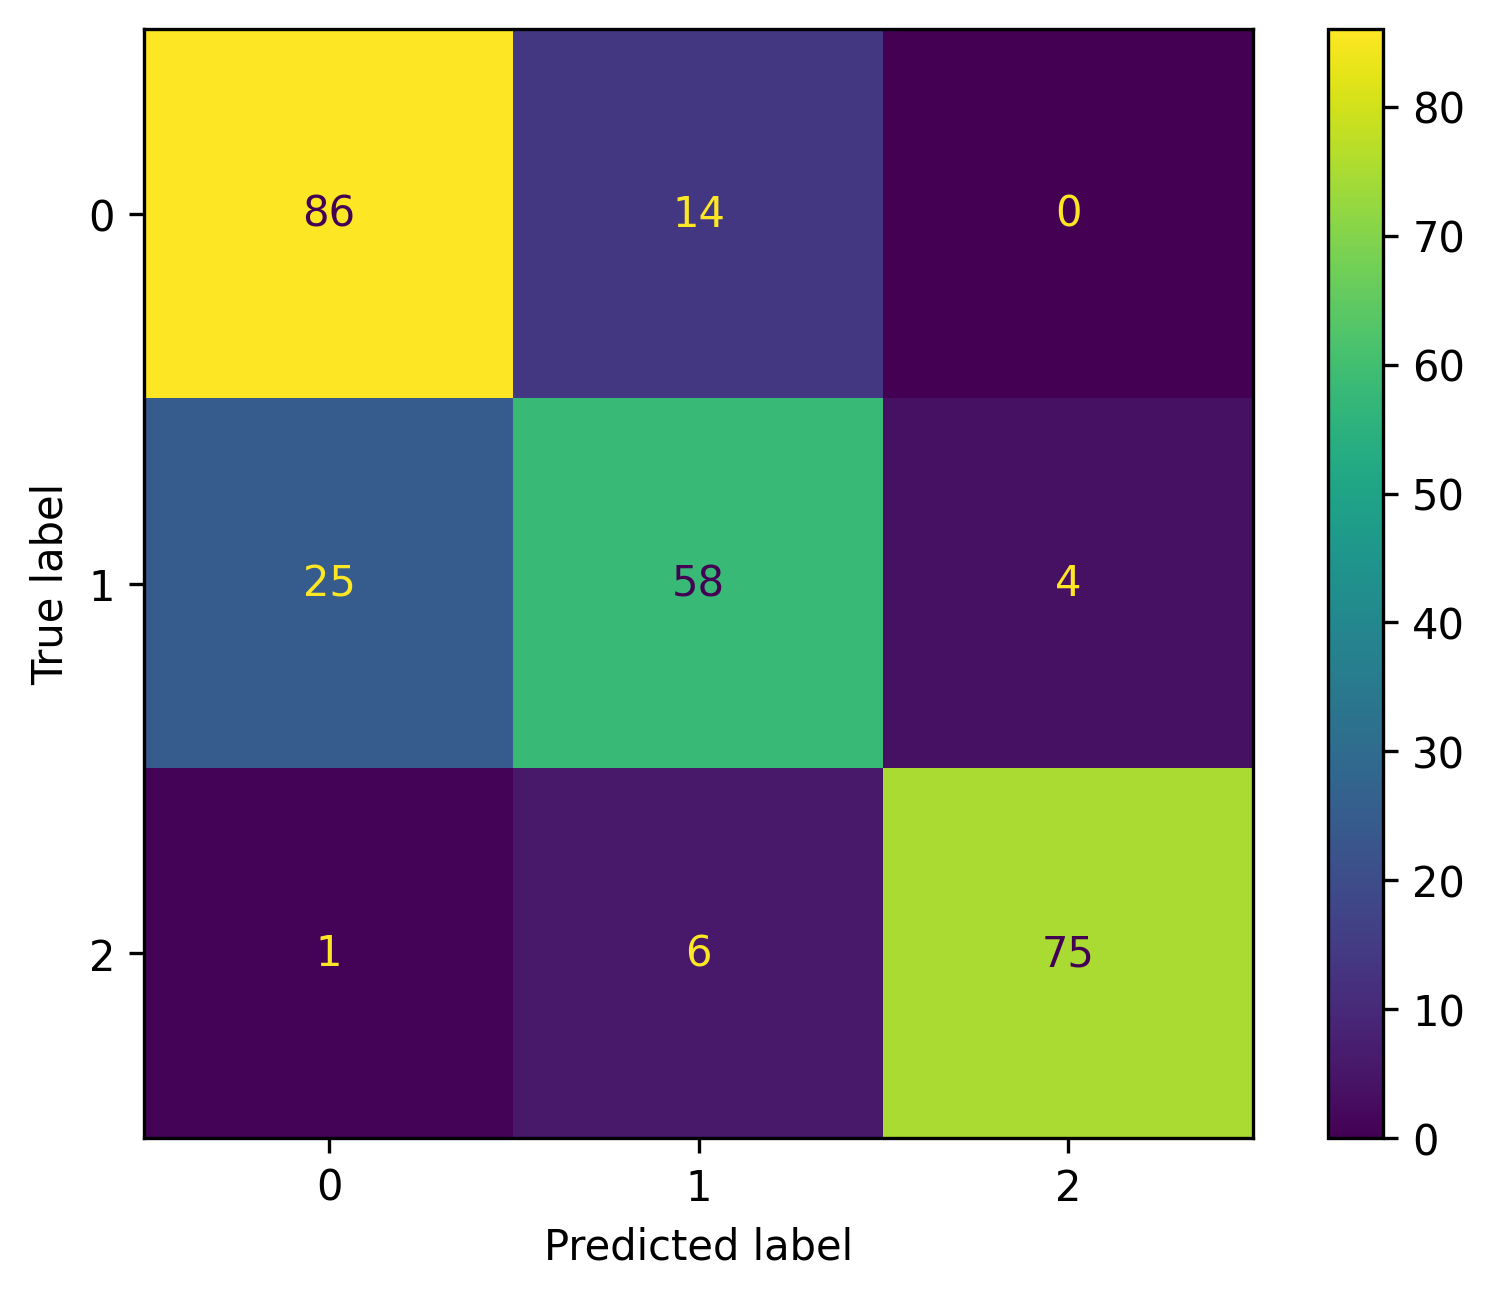

In [119]:
# Confusion matrix
dl_cm = confusion_matrix(y_test, dl_pred_arg, labels = np.arange(0,3))
disp = ConfusionMatrixDisplay(confusion_matrix = dl_cm,
                              display_labels = np.arange(0,3))
print("Deep Learning Confusion Matrix")
disp.plot()
plt.show()

In [120]:
# Prediction rates
calculatePredictionRates("Deep Learning", dl_acc, dl_cm)

Model: Deep Learning
Accuracy: 0.8141263723373413
Confusion Matrix:
[[86 14  0]
 [25 58  4]
 [ 1  6 75]]


In [121]:
# Train/Test Performance Metrics
def calculateDLPerformance(classifier, X_train, y_train, X_test, y_test):
    train_pred = np.argmax(classifier.predict(X_train), axis = 1)
    test_pred = np.argmax(classifier.predict(X_test), axis = 1)
    scores = {
        "Train Accuracy": accuracy_score(y_train, train_pred),
        "Test Accuracy": accuracy_score(y_test, test_pred),
        "Train Recall": recall_score(y_train, train_pred, average = None),
        "Test Recall": recall_score(y_test, test_pred, average = None),
        "Train Precision": precision_score(y_train, train_pred, average = None), 
        "Test Precision": precision_score(y_test, test_pred, average = None), 
        "Train F1": f1_score(y_train, train_pred, average = None),
        "Test F1": f1_score(y_test, test_pred, average = None) 
    }
    print("Model Performance Metrics Comparison")
    return scores

In [122]:
dl_pm = pd.DataFrame(calculateDLPerformance(dl_clf, X_trainStandart, y_train, X_testStandart, y_test))*100
dl_pm

9/9 [==============================] - 0s 2ms/step
Model Performance Metrics Comparison


,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,87.220447,81.412639,92.703863,86.000000,81.203008,76.785714,86.573146,81.132075
1,87.220447,81.412639,76.354680,66.666667,85.164835,74.358974,80.519481,70.303030
2,87.220447,81.412639,92.105263,91.463415,98.314607,94.936709,95.108696,93.167702


In [123]:
# Updating comparison lists
updateLists("DeepLearning", dl_clf, dl_pred_arg, dl_acc, dl_cm, dl_f1, dl_pm, dl_prec, dl_recall, dl_acc_tr)

# **5.Model Comparison**

The XGB model has the best accuracy score on the test set. SVC and Deep Learning models follow in order.

As can be seen from the confusion matrices, Random Forest model predict low risk level more correctly. Likewise XGB, SVC and Deep Learning models predict mid risk level more correctly. But since this is a medical data set, the most important predictions for us  are about high risk level. Again XGB, SVC and Deep Learning models predict high risk level more correctly.

So, most balanced and high accurate model seems XGB model for this data set.